<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">
*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb) | [Contents](Index.ipynb) | [Fancy Indexing](02.07-Fancy-Indexing.ipynb) >

# 比较、掩码、布尔运算

# Comparisons, Masks, and Boolean Logic

这章节介绍如何利用布尔掩码检查或操纵 NumPy 数组中的数据。在通过某些条件式对数据进行提取、修改、计数或者是其他形式的运算的时候会用到掩码。例如，你希望统计所有大于某个数值的数据的格式，或者是删掉那些超过某个阈值的数据的时候。在 NumPy 中，布尔掩码通常也是完成以上类似任务运算速度最快的方法。

This section covers the use of Boolean masks to examine and manipulate values within NumPy arrays.
Masking comes up when you want to extract, modify, count, or otherwise manipulate values in an array based on some criterion: for example, you might wish to count all values greater than a certain value, or perhaps remove all outliers that are above some threshold.
In NumPy, Boolean masking is often the most efficient way to accomplish these types of tasks.

## 一个例子：计算下雨的天数

## Example: Counting Rainy Days

想象一下，你有一系列数据代表一个城市每年的降水量。例如，我们将使用 Pandas 加载 2014 年西雅图的每日降雨量统计数据（详见[第3章](03.00-Introduction-to-Pandas.ipynb)）：

Imagine you have a series of data that represents the amount of precipitation each day for a year in a given city.
For example, here we'll load the daily rainfall statistics for the city of Seattle in 2014, using Pandas (which is covered in more detail in [Chapter 3](03.00-Introduction-to-Pandas.ipynb)):

In [28]:
import numpy as np
import pandas as pd

# use pandas to extract rainfall inches as a NumPy array
rainfall = pd.read_csv('data/Seattle2014.csv')['PRCP'].values
inches = 1.0 * rainfall / 254  # 1/10mm -> inches
inches.shape

(365,)

数组包含 365 个值，从 2014 年 1 月 1 日到 2014 年 12 月 31 日，每日降雨量以英寸为单位。先做一个初步的可视化：让我们看看使用 Matplotlib 生成的雨天的直方图（我们将在[第4章](04.00-Introduction-To-Matplotlib.ipynb)更全面地探讨这个工具）：

The array contains 365 values, giving daily rainfall in inches from January 1 to December 31, 2014.

As a first quick visualization, let's look at the histogram of rainy days, which was generated using Matplotlib (we will explore this tool more fully in [Chapter 4](04.00-Introduction-To-Matplotlib.ipynb)):

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # set plot styles

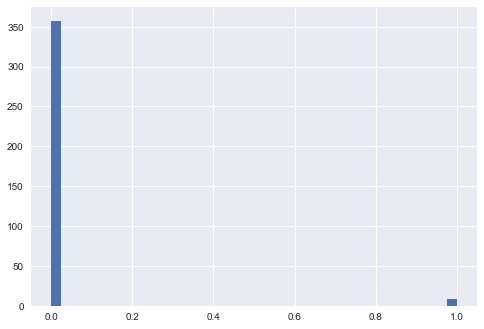

In [3]:
plt.hist(inches, 40);

这个直方图给出了数据的大体的统计信息：和大家的印象不符，在西雅图 2015 年大多是时候的降雨量接近于零。但是这样还是看不到一些具体的信息，我们想看到：比如，一年中有多少雨天？这些雨天的平均降水量是多少？有多少天的降雨量超过半英寸？

This histogram gives us a general idea of what the data looks like: despite its reputation, the vast majority of days in Seattle saw near zero measured rainfall in 2014.
But this doesn't do a good job of conveying some information we'd like to see: for example, how many rainy days were there in the year? What is the average precipitation on those rainy days? How many days were there with more than half an inch of rain?

### 深入数据

### Digging into the data

一种方法是手动运算来获取结果：循环遍历数据，如果我们看到在某个期望范围内的值就递增计数器。通过前面章节的介绍，我们知道这种方法是非常低效的，无论是从编写代码的时间还是运算的时间。我们在[NumPy 数组的计算方式：Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb)中看到：NumPy 的 ufuncs 可以代替循环，对数组进行快速的算术运算; 我们可以以同样的方式使用其他 ufuncs 对数组进行逐元素的*比较*，然后我们对这个结果做处理就能回答上面的问题。我们暂且放下这个问题，先了解下 NumPy 中的那些用*掩码*来解答类似问题的工具。

One approach to this would be to answer these questions by hand: loop through the data, incrementing a counter each time we see values in some desired range.
For reasons discussed throughout this chapter, such an approach is very inefficient, both from the standpoint of time writing code and time computing the result.
We saw in [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) that NumPy's ufuncs can be used in place of loops to do fast element-wise arithmetic operations on arrays; in the same way, we can use other ufuncs to do element-wise *comparisons* over arrays, and we can then manipulate the results to answer the questions we have.
We'll leave the data aside for right now, and discuss some general tools in NumPy to use *masking* to quickly answer these types of questions.

## 作为比较运算符的 ufuncs

## Comparison Operators as ufuncs

在[NumPy 数组的计算方式：Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb)中介绍了 ufuncs，并介绍了加减乘除以及其他相似的算术运算符。Ufuncs 同样支持 ``<`` ``>`` 这样的比较运算符。这种运算的结果是一个布尔值数组，所有比较运算符（一共 6 个）都支持 ufunc 形式的运算：

In [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) we introduced ufuncs, and focused in particular on arithmetic operators. We saw that using ``+``, ``-``, ``*``, ``/``, and others on arrays leads to element-wise operations.
NumPy also implements comparison operators such as ``<`` (less than) and ``>`` (greater than) as element-wise ufuncs.
The result of these comparison operators is always an array with a Boolean data type.
All six of the standard comparison operations are available:

In [4]:
x = np.array([1, 2, 3, 4, 5])

In [5]:
x < 3  # less than

array([ True,  True, False, False, False], dtype=bool)

In [6]:
x > 3  # greater than

array([False, False, False,  True,  True], dtype=bool)

In [7]:
x <= 3  # less than or equal

array([ True,  True,  True, False, False], dtype=bool)

In [8]:
x >= 3  # greater than or equal

array([False, False,  True,  True,  True], dtype=bool)

In [9]:
x != 3  # not equal

array([ True,  True, False,  True,  True], dtype=bool)

In [10]:
x == 3  # equal

array([False, False,  True, False, False], dtype=bool)

当然也支持对两个数组的每一个元素做比较，并且其他的复合表达式也都可以支持：

It is also possible to do an element-wise comparison of two arrays, and to include compound expressions:

In [11]:
(2 * x) == (x ** 2)

array([False,  True, False, False, False], dtype=bool)

和算术运算符一样，比较运算符同样是一个个的 ufuncs，比如 ``x < 3`` 实际上是 ``np.less(x, 3)``。下表是对这些运算符和其对应的 ufunc 的一个展示：

As in the case of arithmetic operators, the comparison operators are implemented as ufuncs in NumPy; for example, when you write ``x < 3``, internally NumPy uses ``np.less(x, 3)``.
    A summary of the comparison operators and their equivalent ufunc is shown here:

| Operator	    | Equivalent ufunc    || Operator	   | Equivalent ufunc    |
|---------------|---------------------||---------------|---------------------|
|``==``         |``np.equal``         ||``!=``         |``np.not_equal``     |
|``<``          |``np.less``          ||``<=``         |``np.less_equal``    |
|``>``          |``np.greater``       ||``>=``         |``np.greater_equal`` |

同样比较运算符也支持不同长度和维度的数据比较，比如这个二维数组的情况：

Just as in the case of arithmetic ufuncs, these will work on arrays of any size and shape.
Here is a two-dimensional example:

In [12]:
rng = np.random.RandomState(0)
x = rng.randint(10, size=(3, 4))
x

array([[5, 0, 3, 3],
       [7, 9, 3, 5],
       [2, 4, 7, 6]])

In [13]:
x < 6

array([[ True,  True,  True,  True],
       [False, False,  True,  True],
       [ True,  True, False, False]], dtype=bool)

不论何种方式，比较运算的结果都是一个布尔值的数组，NumPy 提供了一些使用这些布尔数组的运算方式。

In each case, the result is a Boolean array, and NumPy provides a number of straightforward patterns for working with these Boolean results.

## 使用布尔数组

## Working with Boolean Arrays

布尔数组可以用于很多便捷的运算。这里我们采用之前创建的 ``x`` 举一个例子。

Given a Boolean array, there are a host of useful operations you can do.
We'll work with ``x``, the two-dimensional array we created earlier.

In [14]:
print(x)

[[5 0 3 3]
 [7 9 3 5]
 [2 4 7 6]]


### 计数

### Counting entries

用 ``np.count_nonzero`` 计算 ``True`` 元素的格式：

To count the number of ``True`` entries in a Boolean array, ``np.count_nonzero`` is useful:

In [15]:
# how many values less than 6?
np.count_nonzero(x < 6)

8

数组中有 8 个数据小于 6。另一种计数的方式是采用 ``np.sum`` 函数，因为 ``False`` 会被记为 ``0`` 而 ``True`` 会被记为 ``1``：

We see that there are eight array entries that are less than 6.
Another way to get at this information is to use ``np.sum``; in this case, ``False`` is interpreted as ``0``, and ``True`` is interpreted as ``1``:

In [16]:
np.sum(x < 6)

8

``sum()`` 的另一个好处是它能像其他聚合函数那样，按照行或者按照列运算：

The benefit of ``sum()`` is that like with other NumPy aggregation functions, this summation can be done along rows or columns as well:

In [17]:
# how many values less than 6 in each row?
np.sum(x < 6, axis=1)

array([4, 2, 2])

这里展示了矩阵中每一行小于 6 的数据的个数。如果我们想要检查是否所有的数据或者是至少有一个是 ``True`` 我们可以使用 ``np.any`` 或者 ``np.all``：

This counts the number of values less than 6 in each row of the matrix.

If we're interested in quickly checking whether any or all the values are true, we can use (you guessed it) ``np.any`` or ``np.all``:

In [19]:
# are there any values greater than 8?
np.any(x > 8)

True

In [20]:
# are there any values less than zero?
np.any(x < 0)

False

In [21]:
# are all values less than 10?
np.all(x < 10)

True

In [22]:
# are all values equal to 6?
np.all(x == 6)

False

``np.all`` 和 ``np.any`` 也可以按照特定的轴（axis）运算：

In [23]:
# are all values in each row less than 4?
np.all(x < 8, axis=1)

array([ True, False,  True], dtype=bool)

可以看到第一行与第三行所有所有元素都小于 8。然后要注意，在[聚合：最大值，最小值以及其他](02.04-Computation-on-arrays-aggregates.ipynb)提到，Python 有内置的 ``sum()`` ``any()`` 和 ``all()`` 函数，它们和 NumPy 中的运算略有区别，尤其是在用于多维数组的情况。一定要确保自己用的是 ``np.sum()`` ``np.any()`` 以及 ``np.all()``。

Here all the elements in the first and third rows are less than 8, while this is not the case for the second row.

Finally, a quick warning: as mentioned in [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb), Python has built-in ``sum()``, ``any()``, and ``all()`` functions. These have a different syntax than the NumPy versions, and in particular will fail or produce unintended results when used on multidimensional arrays. Be sure that you are using ``np.sum()``, ``np.any()``, and ``np.all()`` for these examples!

### 布尔运算

### Boolean operators

我们已经看到了我们如何计数了，比如计算雨天小于4英寸的日子，或者雨天大于2英寸的日子。但是如果我们想知道雨量小于四英寸同时大于一英寸的天数怎么办？可以通过 Python 的*按位运算符* ``&``，``|``，``^``，和 ``~`` 做到。与标准算术运算符一样，NumPy 将这些运算符重载为 ufuncs，它们作用于数组中的每一个元素。

We've already seen how we might count, say, all days with rain less than four inches, or all days with rain greater than two inches.
But what if we want to know about all days with rain less than four inches and greater than one inch?
This is accomplished through Python's *bitwise logic operators*, ``&``, ``|``, ``^``, and ``~``.
Like with the standard arithmetic operators, NumPy overloads these as ufuncs which work element-wise on (usually Boolean) arrays.

我们可以用如下的方式获取以上复合条件的答案：

For example, we can address this sort of compound question as follows:

In [30]:
np.sum((inches > 0.5) & (inches < 1))

29

有 29 天的降雨量在 0.5 到 1.0 英寸之间。注意，考虑的各个运算符的优先级，这里的括号是必须的，去掉括号会导致运算成为下面这个样子：

So we see that there are 29 days with rainfall between 0.5 and 1.0 inches.

Note that the parentheses here are important–because of operator precedence rules, with parentheses removed this expression would be evaluated as follows, which results in an error:

``` python
inches > (0.5 & inches) < 1
```

*A AND B* 与 *NOT (A OR B)*的运算结果是一样的（你最好有对于逻辑运算的一些基本了解），我们可以用下面的运算获取同样的结果：

Using the equivalence of *A AND B* and *NOT (A OR B)* (which you may remember if you've taken an introductory logic course), we can compute the same result in a different manner:

In [31]:
np.sum(~( (inches <= 0.5) | (inches >= 1) ))

29

把比较运算和布尔运算一起使用就能进行各种各样高效的逻辑运算了。下面的表格展示了布尔运算符和它们所等价的 ufuncs：

Combining comparison operators and Boolean operators on arrays can lead to a wide range of efficient logical operations.

The following table summarizes the bitwise Boolean operators and their equivalent ufuncs:

| Operator	    | Equivalent ufunc    || Operator	    | Equivalent ufunc    |
|---------------|---------------------||---------------|---------------------|
|``&``          |``np.bitwise_and``   ||&#124;         |``np.bitwise_or``    |
|``^``          |``np.bitwise_xor``   ||``~``          |``np.bitwise_not``   |

有了这些工具，我们就可以去回答有关天气的那些问题了。这里是一些把掩码和聚合一起使用的例子：

Using these tools, we might start to answer the types of questions we have about our weather data.
Here are some examples of results we can compute when combining masking with aggregations:

In [32]:
print("Number days without rain:      ", np.sum(inches == 0))
print("Number days with rain:         ", np.sum(inches != 0))
print("Days with more than 0.5 inches:", np.sum(inches > 0.5))
print("Rainy days with < 0.2 inches  :", np.sum((inches > 0) &
                                                (inches < 0.2)))

('Number days without rain:      ', 215)
('Number days with rain:         ', 150)
('Days with more than 0.5 inches:', 37)
('Rainy days with < 0.2 inches  :', 75)


## 把布尔数组作为掩码使用

## Boolean Arrays as Masks

在前面的部分我们看到可以直接对布尔数组进行聚合。一个更强大的方式是使用布尔数组作为掩码来获取数据本身的特定子集。回到之前的 ``x`` 数组，假设我们想要一个数组中所有小于5的数据：

In the preceding section we looked at aggregates computed directly on Boolean arrays.
A more powerful pattern is to use Boolean arrays as masks, to select particular subsets of the data themselves.
Returning to our ``x`` array from before, suppose we want an array of all values in the array that are less than, say, 5:

In [33]:
x

array([[5, 0, 3, 3],
       [7, 9, 3, 5],
       [2, 4, 7, 6]])

我们可以容易的获取一个执行这个条件的布尔数组：

We can obtain a Boolean array for this condition easily, as we've already seen:

In [34]:
x < 5

array([[False,  True,  True,  True],
       [False, False,  True, False],
       [ True,  True, False, False]], dtype=bool)

如果要获取满足这些条件的数值，我们可以把这个布尔数组作为索引，这就是我们所说的*掩码*运算了：

Now to *select* these values from the array, we can simply index on this Boolean array; this is known as a *masking* operation:

In [35]:
x[x < 5]

array([0, 3, 3, 3, 2, 4])

结果返回一个一维数组，其元素为满足条件式的所有数据；换言之获取的是所谓索引为 ``True`` 的元素。这些运算可以让我们轻易的获取想要的结果，例如在计算西雅图降雨量上的一些统计数据的时候，我们可以这样做：

What is returned is a one-dimensional array filled with all the values that meet this condition; in other words, all the values in positions at which the mask array is ``True``.

We are then free do operate on these values as we wish.
For example, we can compute some relevant statistics on our Seattle rain data:

In [36]:
# construct a mask of all rainy days
rainy = (inches > 0)

# construct a mask of all summer days (June 21st is the 172nd day)
days = np.arange(365)
summer = (days > 172) & (days < 262)

print("Median precip on rainy days in 2014 (inches):   ",
      np.median(inches[rainy]))
print("Median precip on summer days in 2014 (inches):  ",
      np.median(inches[summer]))
print("Maximum precip on summer days in 2014 (inches): ",
      np.max(inches[summer]))
print("Median precip on non-summer rainy days (inches):",
      np.median(inches[rainy & ~summer]))

('Median precip on rainy days in 2014 (inches):   ', 0.19488188976377951)
('Median precip on summer days in 2014 (inches):  ', 0.0)
('Maximum precip on summer days in 2014 (inches): ', 0.85039370078740162)
('Median precip on non-summer rainy days (inches):', 0.20078740157480315)


通过组合布尔运算，掩蔽运算和聚合，我们可以非常快地回答这个数据集上类似的问题。

By combining Boolean operations, masking operations, and aggregates, we can very quickly answer these sorts of questions for our dataset.

## 附录：and / or vs & / |

## Aside: Using the Keywords and/or Versus the Operators &/|

什么会后使用 ``and`` 和 ``or`` 什么时候使用 ``&`` 和 ``|`` 以及它们的区别是一个让人容易弄错的地方。首先，``and`` ``or`` 是对*整个对象*衡量其真假，但是 ``&`` ``|`` 是*按照位*做运算。使用 ``and`` ``or`` 意味着把整个 Python 对象认为是一个布尔值：在 Python 中所有非 0 整数都被认为是 ``True``。

One common point of confusion is the difference between the keywords ``and`` and ``or`` on one hand, and the operators ``&`` and ``|`` on the other hand.
When would you use one versus the other?

The difference is this: ``and`` and ``or`` gauge the truth or falsehood of *entire object*, while ``&`` and ``|`` refer to *bits within each object*.

When you use ``and`` or ``or``, it's equivalent to asking Python to treat the object as a single Boolean entity.
In Python, all nonzero integers will evaluate as True. Thus:

In [37]:
bool(42), bool(0)

(True, False)

In [38]:
bool(42 and 0)

False

In [39]:
bool(42 or 0)

True

对整数进行 ``&`` ``|`` 运算，是进行位运算：对整数的每一位进行 *and* 或者 *or* 运算：

When you use ``&`` and ``|`` on integers, the expression operates on the bits of the element, applying the *and* or the *or* to the individual bits making up the number:

In [40]:
bin(42)

'0b101010'

In [41]:
bin(59)

'0b111011'

In [42]:
bin(42 & 59)

'0b101010'

In [43]:
bin(42 | 59)

'0b111011'

可以看到对应的位会执行计算获取最后的结果。对于 NumPy 的布尔数组来说，可以认为它的每一个元素是一个位，并且 ``1 = True`` ``0 = False`` 它的运算就和 ``&`` ``|`` 是类似的：

Notice that the corresponding bits of the binary representation are compared in order to yield the result.

When you have an array of Boolean values in NumPy, this can be thought of as a string of bits where ``1 = True`` and ``0 = False``, and the result of ``&`` and ``|`` operates similarly to above:

In [44]:
A = np.array([1, 0, 1, 0, 1, 0], dtype=bool)
B = np.array([1, 1, 1, 0, 1, 1], dtype=bool)
A | B

array([ True,  True,  True, False,  True,  True], dtype=bool)

在数组间执行 ``or`` 运算实际上是对真个数组执行布尔运算：

Using ``or`` on these arrays will try to evaluate the truth or falsehood of the entire array object, which is not a well-defined value:

In [45]:
A or B

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

所以在数组上执行布尔运算需要使用 ``|`` ``&`` 而不是 ``or`` ``and``：

Similarly, when doing a Boolean expression on a given array, you should use ``|`` or ``&`` rather than ``or`` or ``and``:

In [46]:
x = np.arange(10)
(x > 4) & (x < 8)

array([False, False, False, False, False,  True,  True,  True, False, False], dtype=bool)

对整个数组判断它们的真假会像前面那样出现 ``ValueError`` 这样的报错：

Trying to evaluate the truth or falsehood of the entire array will give the same ``ValueError`` we saw previously:

In [47]:
(x > 4) and (x < 8)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

所以要记住 ``and`` ``or`` 是对整个对象执行布尔运算，而 ``&`` ``|`` 是对其内容执行布尔运算（单个位或者是单个元素）。对于 NumPy 的布尔数组来说，基本上都是要采用后者进行运算的。

So remember this: ``and`` and ``or`` perform a single Boolean evaluation on an entire object, while ``&`` and ``|`` perform multiple Boolean evaluations on the content (the individual bits or bytes) of an object.
For Boolean NumPy arrays, the latter is nearly always the desired operation.

<!--NAVIGATION-->
< [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb) | [Contents](Index.ipynb) | [Fancy Indexing](02.07-Fancy-Indexing.ipynb) >